# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 3 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 133

# Apartado 1: Clasificador de noticias

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [2]:
import pandas as pd
import numpy as np

file = 'BBC News.csv'
csv = pd.read_csv(file, sep=',')
df = pd.DataFrame(csv, columns = ['Text','Category']) #importar csv sin ArticleId

In [3]:
# Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías.
# Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.
#------------------------------------------------------------------------------

df['Category'].value_counts() #cuenta las veces que aparece cada valor 

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

Hay una diferencia de 85 noticias entre la categoría de deportes y de tecnología. Teniendo en cuenta que es un tercio más de noticias pero son dos categorías bastante con vocabularios distintos, no debería suponer un gran problema.

In [4]:
#Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.
#------------------------------------------------------------------------------

print(df.Text[63])
print(df.Category[63])

what high-definition will do to dvds first it was the humble home video  then it was the dvd  and now hollywood is preparing for the next revolution in home entertainment - high-definition.  high-definition gives incredible  3d-like pictures and surround sound. the dvd disks and the gear to play them will not be out for another year or so  and there at are still a number of issues to be sorted out. but when high-definition films do come out on the new format dvds  it will profoundly change home entertainment. for rick dean  director of business development for digital content company thx  a high-definition future is an exciting prospect. he has worked on the star wars dvd trilogy  finding nemo  the incredibles and indiana jones.  there was a time not so long ago when the film world and the video world were two completely separate worlds   he told the bbc news website.   the technology we are dealing with now means they are very much conjoined.  the film that we see in theatres is comin

El artículo habla del avance que supone la alta definición desde un enfoque técnico, por lo que encaja en la sección de tecnología.

In [5]:
# Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test
# usando la función `train_test_split` de sklearn. 
#------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2,random_state=RANDOM_STATE) #mezclo y cojo el 20% para prueba

#Como los indices no se corresponden a la posicion de la lista y sufrimos el riesgo de acceder
#a una posicion vacía, los reajustamos con un dataframe nuevo

aux = {'Text': train_data.Text.tolist(), 
        'Category': train_data.Category.tolist()}
train_data = pd.DataFrame(aux, columns=['Text', 'Category'])

aux = {'Text': test_data.Text.tolist(),
        'Category': test_data.Category.tolist()}
test_data = pd.DataFrame(aux, columns=['Text', 'Category'])

print(train_data) #entrenamiento
print(test_data) #prueba

                                                   Text  Category
0     warning over us pensions deficit taxpayers may...  business
1     collins calls for chambers return world 100m c...     sport
2     safety alert as gm recalls cars the world s bi...  business
3     jp morgan admits us slavery links thousands of...  business
4     clarke to press on with id cards new home secr...  politics
...                                                 ...       ...
1187  us in eu tariff chaos trade row the us has ask...  business
1188  benitez  to launch morientes bid  liverpool ma...     sport
1189  progress on new internet domains by early 2005...      tech
1190  mauresmo opens with victory in la amelie maure...     sport
1191  henman decides to quit davis cup tim henman ha...     sport

[1192 rows x 2 columns]
                                                  Text       Category
0    boris opposes mayor apology ken livingstone sh...       politics
1    wenger signs new deal arsenal manager 

## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Aprovecharemos para quitar las palabras que contengas caracteres que no sean letras.
vectorizer = CountVectorizer(stop_words='english', binary=False,ngram_range=(1,1), token_pattern=r'(?u)\b[A-Za-z]+\b') 

In [10]:
# Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test.
#------------------------------------------------------------------------------

# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(train_data.Text)

# Hacemos lo mismo con el conjunto de test.
# Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data.Text)

# Guardamos las palabras de nuestro diccionario usadas en la vectorización
feature_names = vectorizer.get_feature_names() 

In [11]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [12]:
# Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada.
# ¿Qué palabras se han eliminado y por qué?
#------------------------------------------------------------------------------
write_terms(feature_names, train_data.Text, train_vector_data,38)

Mensaje 38 : eminem beats elvis to number one rapper eminem has denied elvis his fourth number one of the year  after his song  like toy soldiers  stormed to the top of the singles charts.  the track claimed the top spot ahead of the king s latest re-release  are you lonesome tonight. it is the fifth in a series of 18 reissues to mark the 70th anniversary of presley s birth. almost here  the duet from former westlife star brian mcfadden and delta goodrem  went in at number three.  like toy soldiers  from eminem s encore album  is sampled from martika s 1980s hit toy soldiers. it takes a swipe at hip-hop feuds and follows the success of just lose it. last week s number one  elvis s it s now or never  slipped 13 places to number 14  but all five of his re-released songs are in the top 40. one world project tsunami fundraiser  grief never grows old  slipped four places to number eight. featuring cliff richard and boy george  the song was written by former dj mike read. in the album charts

Se han eliminado preposiciones y determinantes. Sin embargo, recupera palabras como 's', probablemente porque lo trata como si se refiriese a la letra, cuando realmente es el resultado de perder la tilde en una contracción. Por ejemplo: "it's now or never" se queda como "it s now or never".

In [13]:
# Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test.
#------------------------------------------------------------------------------

from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_data['Category']) #entrenamos el clasificador

mnb_train_predictions = mnb_classifier.predict(train_vector_data) #pedimos predicciones del conjunto de entrenamiento
mnb_test_predictions = mnb_classifier.predict(test_vector_data) #pedimos predicciones del conjunto de test

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_data['Category']))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_data['Category']))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.99748322147651
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9798657718120806


In [14]:
# A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases.
#------------------------------------------------------------------------------

#Con test_data['Category'].value_counts() se ve la cantidad de cada categoría
#para ordenarlos correctamente a la hora de usar classification_report.
test_data['Category'].value_counts()

business         72
sport            62
entertainment    60
politics         53
tech             51
Name: Category, dtype: int64

In [12]:
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.
target_names = ['business', 'entertainment', 'politics','sport', 'tech']

from sklearn.metrics import classification_report, confusion_matrix

predictions = mnb_test_predictions #creamos una variable auxiliar para las predicciones

print(classification_report(test_data['Category'], predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       1.00      0.96      0.98        72
entertainment       0.97      0.97      0.97        60
     politics       0.98      1.00      0.99        53
        sport       1.00      1.00      1.00        62
         tech       0.94      0.98      0.96        51

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

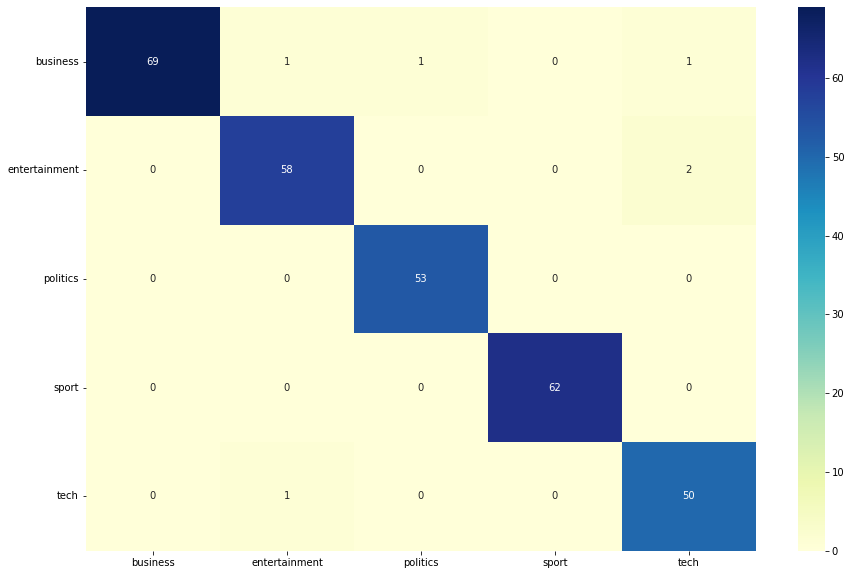

In [13]:
# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------

%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data['Category'], predictions) #creamos la matriz de confusion
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names,
                              columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=0)

Podemos observar que el clasificador hace un muy buen trabajo. La categoría deportiva, por ejemplo, está perfectamente clasificada, y solo ha habido un artículo colocado erróneamente en la de política. Falta algo de precisión en la tecnológica, con tres falsos positivos, y otros tres pertenecientes a la de economía precichos como de otras categorías, aunque la precisión es perfecta.

In [14]:
# A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización.
#------------------------------------------------------------------------------

from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_vector_data, train_data['Category'])

knn_train_predictions = knn_classifier.predict(train_vector_data)
knn_test_predictions = knn_classifier.predict(test_vector_data)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.6870805369127517
k-NN, porcentaje de aciertos en test: 0.540268456375839


In [15]:
# Analiza los resultados, ¿a qué crees que se deben?
#------------------------------------------------------------------------------

predictions = knn_test_predictions

print(classification_report(test_data['Category'], predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.91      0.42      0.57        72
entertainment       0.78      0.42      0.54        60
     politics       0.94      0.57      0.71        53
        sport       0.33      1.00      0.50        62
         tech       1.00      0.27      0.43        51

     accuracy                           0.54       298
    macro avg       0.79      0.53      0.55       298
 weighted avg       0.78      0.54      0.55       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

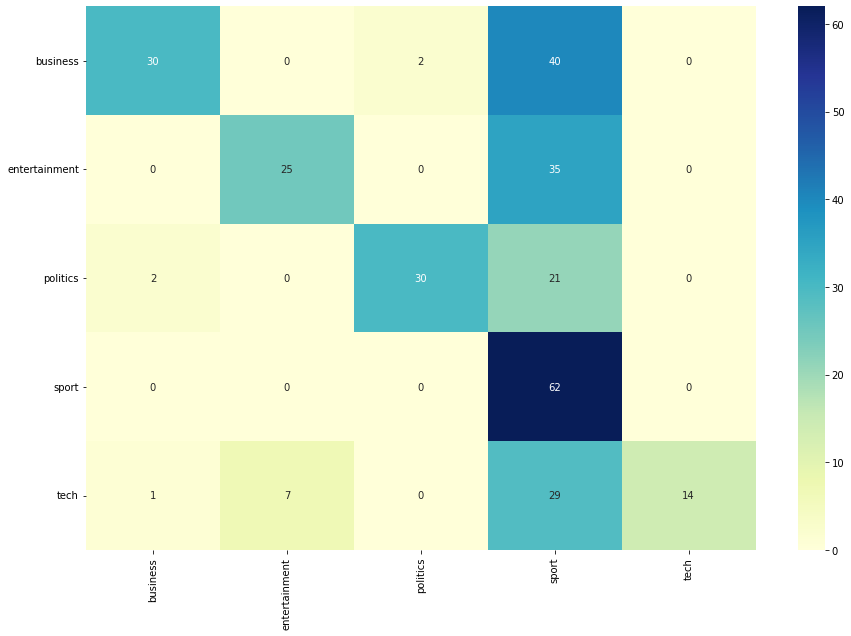

In [16]:
%matplotlib inline

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names,
                              columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Los resultados obtenidos son mucho peores e irregulares que con Naive Bayes, con categorías como la deportiva con una precisión bajísima pero con una exhaustividad perfecta, siendo el caso opuesto la tecnológica. El resto de categorías siguen el mismo patrón que la tecnológica.

Si observamos la cantidad de articulos del conjunto de entrenamiento...

In [17]:
train_data['Category'].value_counts()

sport            284
business         264
politics         221
entertainment    213
tech             210
Name: Category, dtype: int64

Hay una diferencia tremenda entre los artículos tecnológicos y los económicos con el resto, por lo que se puede sospechar un sobreaprendizaje. Al relacionar k-NN la frecuencia con la que varias palabras se incluyen enun mismo texto, algunas como "team", "win" o incluso "buy" pueden haberse asociado erroneamente junto a otras más comunes con el resto de artículos y así haberlos arrastrado a esta categoría.

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

In [18]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Traducimos el fichero glove a un fichero con formato word2vec
glove_file = 'words.txt'

we_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

we_vocabulary = list(we_model.key_to_index.keys())

we_vectorizer = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary=False,ngram_range=(1,1), token_pattern=r'(?u)\b[A-Za-z]+\b')

#vectorizamos con el vocabulario transformado
we_train_vector_data = we_vectorizer.fit_transform(train_data.Text)
we_test_vector_data=we_vectorizer.transform(test_data.Text)

we_feature_names = we_vectorizer.get_feature_names() #obtenemos las palabras usadas

In [20]:
# Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings).
#------------------------------------------------------------------------------

from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB() #Naive Bayes gaussiano

#Para que no se sature, partimos el conjunto de entrenamiento en bloques
#que contengan una cantidad de vectores divisible entre el número total.
#En nuestro caso tenemos 1192 artículos, por lo que podemos crear 8 bloques
#con 149 vectores cada uno.

num_rows=len(train_data['Category']) 
chunk_size=149 #tamaño del bloque

for i in range(0, (num_rows//chunk_size)): #1192/149 = 8 bloques
    train_chunk = we_train_vector_data[i*chunk_size : (i+1)*chunk_size,:].toarray() #bloque con los vectores
    target_chunk = train_data['Category'][i*chunk_size : (i+1)*chunk_size] #bloque con las categorías
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_data['Category'])) #entrenamiento parcial

In [21]:
# Creamos los arrays antes para ser más eficiente (crea el array grande y luego lo rellena con ceros)
gnb_train_predictions=np.zeros_like(train_data['Category'])
gnb_test_predictions=np.zeros_like(test_data['Category'])

for i in range(0, (num_rows//chunk_size)): #predecimos el conjunto de entrenamiento
    train_chunk = we_train_vector_data[i*chunk_size : (i+1)*chunk_size,:].toarray() #cogemos una seccion
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk) #predecimos esa sección

    
#En nuestro caso, el conjunto de test está formado por 298 vectores,
#número también divisible entre 149, por lo que no hace falta cambiar
#el tamaño del bloque.
num_rows=len(test_data['Category'])

for i in range(0, (num_rows//chunk_size)): #298/149 = 2 bloques
    test_chunk = we_test_vector_data[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == train_data['Category']))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == test_data['Category']))

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 1.0
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.9093959731543624


In [22]:
# Analiza el error por clase y dibuja la matriz de confusión.
#------------------------------------------------------------------------------

predictions = gnb_test_predictions #predicciones del conjunto de test

print(classification_report(test_data['Category'], predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.94      0.92      0.93        72
entertainment       0.90      0.88      0.89        60
     politics       0.91      0.94      0.93        53
        sport       0.98      0.90      0.94        62
         tech       0.81      0.90      0.85        51

     accuracy                           0.91       298
    macro avg       0.91      0.91      0.91       298
 weighted avg       0.91      0.91      0.91       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

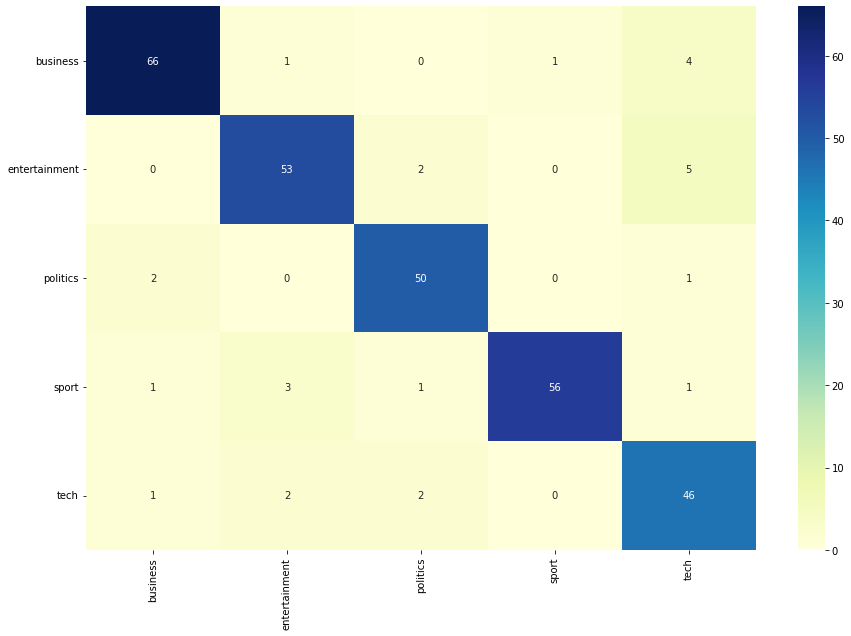

In [23]:
%matplotlib inline

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names,
                              columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Respecto al Naive Bayes sin word-embeddings, observamos que las predicciones sobre el conjunto de entrenamiento son perfectas, pero en el conjunto de test han bajado al 90%. No hay una gran diferencia ni en la precisión ni en la exhaustividad de las distintas clases, si acaso la más destacable es la de tecnología, cuya precisión alcanza poco más del 80%.

Cabe decir que esos artículos mal clasificados como tecnológicos son sobre todo de entretenimiento y de economía, algo lógico teniendo en cuenta que es donde más relación se va a encontrar entre términos usados y sinónimos. En la de entretenimiento hay tres artículos mal clasificados que realmente pertenecen a la deportiva, y se puede aplicar el mismo argumento de antes.

In [24]:
# Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.
#------------------------------------------------------------------------------

we_knn_classifier = neighbors.KNeighborsClassifier()
we_knn_classifier.fit(we_train_vector_data, train_data['Category']) #entrenamos el clasificador

we_knn_train_predictions = we_knn_classifier.predict(we_train_vector_data) #predecimos el conjunto de entrenamiento
we_knn_test_predictions = we_knn_classifier.predict(we_test_vector_data) #predecimos el conjunto de test

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(we_knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", np.mean(we_knn_test_predictions == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.5914429530201343
k-NN, porcentaje de aciertos en test: 0.47315436241610737


In [27]:
predictions = we_knn_test_predictions

print(classification_report(test_data['Category'], predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.84      0.29      0.43        72
entertainment       0.89      0.42      0.57        60
     politics       1.00      0.42      0.59        53
        sport       0.29      1.00      0.45        62
         tech       1.00      0.22      0.35        51

     accuracy                           0.47       298
    macro avg       0.81      0.47      0.48       298
 weighted avg       0.79      0.47      0.48       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

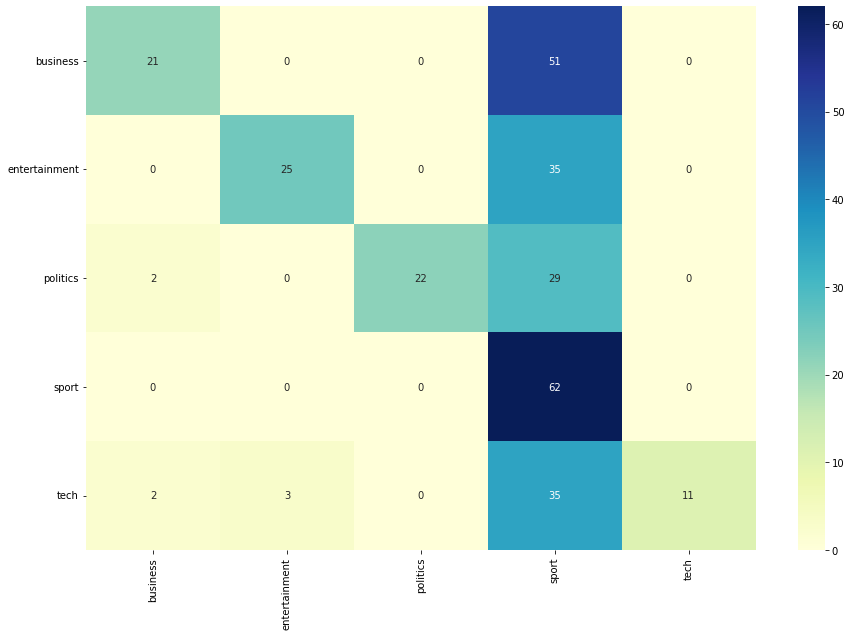

In [28]:
%matplotlib inline

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names,
                              columns=target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

De nuevo, vemos como el uso de word-embeddings ha empeorado los resultados. La precisión se sigue manteniendo alta en todas las categorías menos en la deportiva, que vuelve a tener una exhaustividad perfecta pero cuenta con muchos más textos clasificados erróneamente en esta categoría. De nuevo, puede tratarse de un problema de sobreaprendizaje, ya que este error no se manifiesta solo en las predicciones del conjunto de test, sino también en las del conjunto de entrenamiento. 

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

In [29]:
print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_data['Category']))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_data['Category']))

print("\nk-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data['Category']))

print("\nGaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == train_data['Category']))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == test_data['Category']))

print("\nk-NN con word-embeddings, porcentaje de aciertos en entrenamiento:", np.mean(we_knn_train_predictions == train_data['Category']))
print("k-NN con word-embeddings, porcentaje de aciertos en test:", np.mean(we_knn_test_predictions == test_data['Category']))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.99748322147651
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9798657718120806

k-NN, porcentaje de aciertos en entrenamiento: 0.6870805369127517
k-NN, porcentaje de aciertos en test: 0.540268456375839

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 1.0
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.9093959731543624

k-NN con word-embeddings, porcentaje de aciertos en entrenamiento: 0.5914429530201343
k-NN con word-embeddings, porcentaje de aciertos en test: 0.47315436241610737


En conjunto, se observa que el Naive Bayes ha funcionado mucho mejor que el k-NN, y que el uso de word-embeddings ha desmejorado las predicciones en todos los casos con la excepción del conjunto de entrenamiento en el gaussiano.

Una de las causas más probables por las que k-NN no funcione tan bien sea por la naturaleza de los mensajes. Al tratarse de artículos periodísticos, es normal que haya expresiones o ciertos conjuntos de palabras que se repitan a lo largo de todos los artículos Además, si hay muchos textos de una categoría concreta, puede ser que esté asociando los términos más específicos con otros que son más comunes con el resto, lo que arrastrará a otros textos a ser mal clasificados.

Para las word-embeddings, al funcionar con analogías y con textos grandes (los vectores contienen bastantes palabras), puede estar sucediendo que aquellas palabras claves y representativas de una categoría concreta se vean diluidas por el resto o que no se reconozcan como tal. este puede ser el caso de palabras como "match" y "game", que en ciertos contextos significan lo mismo y pueden confundir si se refiere a un partido de fútbol y a un videojuego, por ejemplo. 

In [32]:
# Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias
# y otro mal clasificado por el k-NN con Word-embeddings. 
#------------------------------------------------------------------------------

for i in range(0, len(test_data['Text'])): #buscamos en el conjunto de test
    if test_data['Category'][i] != mnb_test_predictions[i]: #si la categoría real no es la predicha
        print('Naive Bayes: noticia',i)
        print('Categoria real:', test_data['Category'][i])
        print('Categoria predicha:', mnb_test_predictions[i],'\n')
        break #paramos la búsqueda

for i in range(0, len(test_data['Text'])):
    if test_data['Category'][i] != we_knn_test_predictions[i]:
        print('k-NN con Word-embeddings: noticia',i)
        print('Categoria real:', test_data['Category'][i])
        print('Categoria predicha por k-NN:', we_knn_test_predictions[i])
        break

Naive Bayes: noticia 35
Categoria real: business
Categoria predicha: entertainment 

k-NN con Word-embeddings: noticia 0
Categoria real: politics
Categoria predicha por k-NN: sport


In [40]:
# Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.
#------------------------------------------------------------------------------

write_terms(feature_names, test_data.Text, test_vector_data,35)
print('Categoria real:', test_data['Category'][35])
print('Categoria predicha:', mnb_test_predictions[35],'\n')

Mensaje 35 : mcdonald s boss bell dies aged 44 charlie bell  the straight-talking former head of fast-food giant mcdonald s  has died of cancer aged 44.  mr bell was diagnosed with colorectal cancer in may last year  a month after taking over the top job. he resigned in november to fight the illness. joining the company as a 15-year-old part-time worker  mr bell quickly moved through its ranks  becoming australia s youngest store manager at 19. a popular go-getter  he is credited with helping revive mcdonald s sales. mr bell leaves a wife and daughter.  as we mourn his passing  i ask you to keep charlie s family in your hearts and prayers   chief executive james skinner said in a statement.  and remember that in his abbreviated time on this earth  charlie lived life to the fullest.   no matter what cards life dealt  charlie stayed centred on his love for his family and for mcdonald s.   after running the company s australian business in the 1990s  mr bell moved to the us in 1999 to run

El texto habla de la muerte de un ex-director de McDonalds. Aunque habla de su recorrido en la empresa, también se tocan temas personales y se menciona a su familia. Palabras como "family", "wife", "love", "dumb", "cards" o "daughter" no son propias de un artículo sobre una empresa. Hay otras como "market", "worker", "manager", "business" o "company", pero estas pueden también aplicarse a otros contextos más fácilmente.

In [42]:
write_terms(feature_names, test_data.Text, test_vector_data,0)
print('Categoria real:', test_data['Category'][0])
print('Categoria predicha:', we_knn_test_predictions[0])

Mensaje 0 : boris opposes mayor apology ken livingstone should  stick to his guns  and not apologise for his  nazi  comment to a jewish reporter  tory mp boris johnson has insisted.  mr johnson also claimed tony blair s intervention in the row was  an attempt to reassure jewish voters . london mayor mr livingstone says he is  standing by  his remarks which likened an evening standard journalist to a  concentration camp guard . but the prime minister says it is time for mr livingstone to say sorry.  labour s mr livingstone has said his comments may have been offensive but were not racist  and said earlier this week he would not apologise even if mr blair asked. later the prime minister said:  a lot of us in politics get angry with journalists from time to time  but in the circumstances  and to the journalist because he was a jewish journalist  yes  he should apologise.   however  mr johnson  who was forced to apologise last year for an article in the magazine he edits about liverpudlian

Podemos ver que el vector contiene palabras como "football", "game", "liverpool", "london", "spectator", "fans" o "camp" (que puede asociarse a "field" y por tanto referirse al terreno de juego), y que fácilmente pueden asociarse entre sí para dar a entender que habla de un partido de fútbol. Sin embargo, también se encuentra otro grupo de palabras como "nazi", "muslim", "semitic", "tory", "war", "politics", "prime" o "mayor", por lo que no es de extrañar, al igual que en el artículo anterior, que no supiera discernir entre una categoría u otra.

En ambos casos las versiones vectorizadas mezclan palabras relevantes para dos categorías distintas, además de contener una gran cantidad de ruido con términos como "said", "think", "things" o "year", palabras muy comunes en ambas.

In [43]:
# Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien
# y analiza las palabras más relevantes para clasificar una noticia como de dichas clases.
# Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.
#------------------------------------------------------------------------------

def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [44]:
print_top20_features_per_class_in_NB(vectorizer,mnb_classifier,target_names)  

Top 20 features per class

business: s / said / year / mr / new / market / growth / company / economy / firm / government / bank / economic / oil / years / world / shares / sales / business / companies 

entertainment: s / film / said / best / year / music / new / awards / band / uk / actor / t / director / award / won / films / star / album / number / years 

politics: said / mr / s / labour / government / election / blair / people / party / minister / brown / new / uk / told / howard / plans / public / prime / year / tax 

sport: s / said / game / england / t / year / time / win / world / cup / new / team / players / m / final / match / good / play / half / o 

tech: said / s / people / mobile / new / mr / technology / users / net / software / use / phone / music / year / microsoft / digital / service / make / like / computer 



En general, vemos que en el top de palabras de cada categoría se encuentran "said", "new", "year" y "s" entre las primeras. Si observamos las categorías "entertainment" y "tech", el resto de palabras son únicas a excepción de "music". La razón por la que funciona tan bien este clasificador es porque tiene en cuenta la frecuencia de cada categoría y de que una palabra aparezca en la misma, calculando así la probabilidad de que aparezca en cada clase. Por ello, no se ve tan influído por palabras muy comunes entre todas ellas, ya que el uso de una palabra como "said" es muy alto en todas ellas y se acaba compensando.

Sin embargo, el contexto de las noticias es muy importante, ya que relatan hechos sucedidos a principios de siglo. Pese a que tiene mucho más sentido clasificar "music" dentro de la categoría de entretenimiento, en esos años también hubo una revolución tecnológica respecto a los reproductores portátiles como el iPod y los teléfonos móviles. Siendo este el caso, no es de extrañar que haya una gran cantidad de noticias al respecto en esta categoría y por tanto un término tan identificativo pueda confundirlo.